# 라이브러리 호출

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os, time
import tqdm
import tensorflow_addons as tfa

tqdm_callback = tfa.callbacks.TQDMProgressBar()

# 데이터셋 호출

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_valid, y_valid = x_train[:5000], y_train[:5000]
x_train, y_train = x_train[5000:], y_train[5000:]

In [3]:
class_names= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
print("train :", "x :",x_train.shape, ", y :",y_train.shape)
print("test :", "x :",x_test.shape, ", y :",y_test.shape)
print("valid :", "x :",x_valid.shape, ", y :",y_valid.shape)

train : x : (45000, 32, 32, 3) , y : (45000, 1)
test : x : (10000, 32, 32, 3) , y : (10000, 1)
valid : x : (5000, 32, 32, 3) , y : (5000, 1)


In [5]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
validation_ds = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))

# 전처리

## 데이터 확인

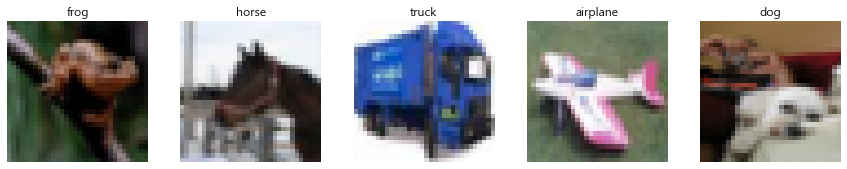

In [6]:
plt.figure(figsize=(15,15))
for i, (image, label) in enumerate(train_ds.take(5)):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(image)
    plt.title(class_names[label.numpy()[0]])
    plt.axis('off')

## 이미지 조정

In [7]:
def process_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    # Resize images from 32x32 to 277x277
    # AlexNet 은 input으로 277x277 을 받기 때문
    image = tf.image.resize(image, (227,227))
    return image, label

## Pipeline

* 이미지 조정
* 데이터셋 셔플
* Batch 설정

In [8]:
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()
print("Training data size:", train_ds_size)
print("Test data size:", test_ds_size)
print("Validation data size:", validation_ds_size)

Training data size: 45000
Test data size: 10000
Validation data size: 5000


In [9]:
train_ds = (train_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))
test_ds = (test_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))
validation_ds = (validation_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))

# 모델 구현

**AlexNet layer**
- Conv layer
- Batch normalisation layer
- Max Pooling layer
- Flatten layer
- Dense layer
- Dropout

**AlexNet Activation**
- ReLU
- Softmax

In [10]:
from tensorflow.keras import models, layers, utils

def Build_AlexNet():
    x = layers.Input(shape=(227,227,3), name="Input")
    
    y = layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', name="C1")(x)
    y = layers.BatchNormalization(name="N1")(y)
    y = layers.MaxPool2D(pool_size=(3,3), strides=(2,2), name="P1")(y)
    
    y = layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same", name="C2")(y)
    y = layers.BatchNormalization(name="N2")(y)
    y = layers.MaxPool2D(pool_size=(3,3), strides=(2,2), name="P2")(y)
    
    y = layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same", name="C3")(y)
    y = layers.BatchNormalization(name="N3")(y)
    
    y = layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same", name="C4")(y)
    y = layers.BatchNormalization(name="N4")(y)
    
    y = layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same", name="C5")(y)
    y = layers.BatchNormalization(name="N5")(y)
    y = layers.MaxPool2D(pool_size=(3,3), strides=(2,2), name="P5")(y)
    
    y = layers.Flatten(name="Flatten")(y)
    y = layers.Dense(4096, activation='relu', name="D1")(y)
    y = layers.Dropout(0.5, name="Drop1")(y)
    y = layers.Dense(4096, activation='relu', name="D2")(y)
    y = layers.Dropout(0.5, name="Drop2")(y)
    y = layers.Dense(10, activation='softmax', name="Output")(y)
    model = models.Model(x,y, name="AlexNet")
    return model

alex = Build_AlexNet()

# Tensorboard

In [11]:
root_logdir = os.path.join(os.curdir, "logs\\fit\\")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

# Compile

In [12]:
alex.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.optimizers.SGD(learning_rate=0.001),
              metrics=['accuracy'])
alex.summary()

Model: "AlexNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 227, 227, 3)]     0         
                                                                 
 C1 (Conv2D)                 (None, 55, 55, 96)        34944     
                                                                 
 N1 (BatchNormalization)     (None, 55, 55, 96)        384       
                                                                 
 P1 (MaxPooling2D)           (None, 27, 27, 96)        0         
                                                                 
 C2 (Conv2D)                 (None, 27, 27, 256)       614656    
                                                                 
 N2 (BatchNormalization)     (None, 27, 27, 256)       1024      
                                                                 
 P2 (MaxPooling2D)           (None, 13, 13, 256)       0   

# fit

In [ ]:
alex.fit(train_ds,
          epochs=50,
          validation_data=validation_ds,
          validation_freq=1,
          verbose=0,
          callbacks=[tqdm_callback])

Training:   0%|                                                                                0/50 ETA: ?s,  …

Epoch 1/50


0/1406                                                                                                       E…